In [84]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
mbti_df=pd.read_csv("01_MBTI_DataCleaned.csv")

In [21]:
mbti_df.head()

,type,posts,text_cleaned,tokens_text,type_index
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moments sportscenter top ten plays p...,"['enfp', 'intj', 'moments', 'sportscenter', 't...",8
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack posts alarming sex boring positio...,"['finding', 'lack', 'posts', 'alarming', 'sex'...",3
2,INTP,'Good one _____ https://www.youtube.com/wat...,one course say know blessing curse absolutely ...,"['one', 'course', 'say', 'know', 'blessing', '...",11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",intp enjoyed conversation day esoteric gabbing...,"['intp', 'enjoyed', 'conversation', 'day', 'es...",10
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,"['fired', 'another', 'silly', 'misconception',...",2


In [29]:
mbti_df.shape

(8675, 5)

In [32]:
mbti_df = mbti_df.loc[~mbti_df['text_cleaned'].apply(lambda x: isinstance(x, float))]
mbti_df.shape

(8674, 5)

### Class Balance

In [143]:
#Column with clean text
textVar = mbti_df["text_cleaned"]

#Target columns (sentiment, class, etc.)
targetVar = mbti_df["type"]

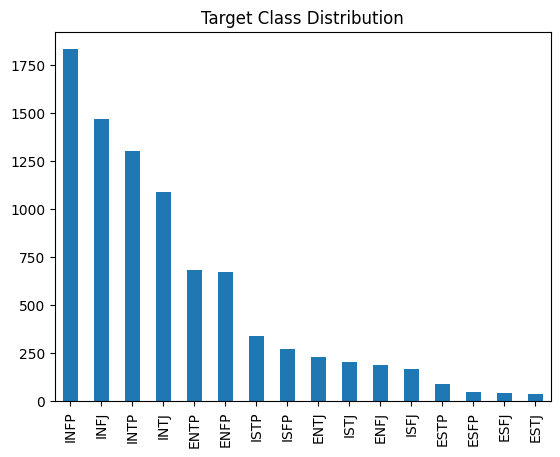

In [144]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

In [63]:
mbti_raw = mbti_df.copy()

In [73]:
grouped = mbti_raw.groupby('type')
mbti_bal = pd.DataFrame(grouped.apply(lambda x: x.sample(grouped.size().min())))
mbti_bal.reset_index(drop=True, inplace=True)

In [74]:
mbti_bal.shape

(624, 5)

In [75]:
# #Column with clean text
# textVar = mbti_bal["text_cleaned"]
# #Target columns (sentiment, class, etc.)
# targetVar = mbti_bal["type"]

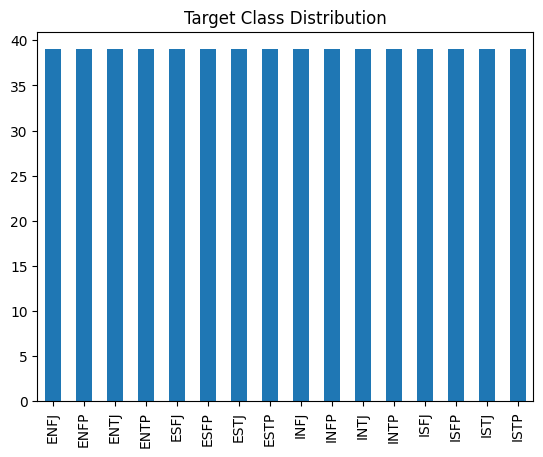

In [76]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

In [179]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Training parameters. Here we specify the training of the net will use 64 examples for each backprop iteration
batch_size = 16
# We will go thru the entire data set 20 times
num_epochs = 20

# Prepossessing parameters
# We will only input the first "sequence_length" words of every Yelp review (and pad out with nulls if the text is < "sequence_length
# We will also build our model using the most frequent 20000 words in our tweet 'dictionary'
sequence_length = 8000
max_features = 20000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
# num_classes = 1
num_classes = targetVar.nunique()

In [180]:
X = textVar.values
Y = pd.get_dummies(targetVar).values

In [181]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X,Y, stratify=targetVar, test_size = 0.33, random_state = 1010)

In [182]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_labels.shape)
print(val_samples.shape,val_labels.shape)

(5811,) (5811, 16)
(2863,) (2863, 16)


In [183]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2023-05-23 19:00:21.844035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5811]
	 [[{{node Placeholder/_0}}]]


In [184]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'like', 'think', 'people']

In [185]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in val_samples])).numpy()

Y_train = np.array(train_labels)
Y_test = np.array(val_labels)

In [186]:
import os, re, time

embeddings_index = {}

glove_dir = '/home/jupyter/wordvec/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [187]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [188]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19199 words (801 misses)


In [189]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,)

In [190]:
from tensorflow.keras import regularizers


In [191]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(64, 3, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(3)(x)
# x = layers.Conv1D(64, 3, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(64, 3, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense((num_classes), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_26 (Conv1D)          (None, None, 64)          19264     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, None, 64)          12352     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                        

In [192]:
# filepath="/home/jupyter/data/dl_models/cnn_glove_multi_weights_best"

# checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
#                              verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
# #only save model if it improves the accuracy

# callbacks_list = [checkpoint]

# Define early stopping callback
#early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

t1 = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test),
                    #callbacks = [early_stopping],
                    verbose=2)
t2 = time.time()
print("CNN Glove model train time = %d seconds" %(t2-t1))

CNN_static_glove_multiclass_history = history

Epoch 1/20
364/364 - 34s - loss: 2.6525 - acc: 0.1831 - val_loss: 2.3165 - val_acc: 0.2669 - 34s/epoch - 92ms/step
Epoch 2/20
364/364 - 31s - loss: 2.2950 - acc: 0.2586 - val_loss: 2.2095 - val_acc: 0.2864 - 31s/epoch - 86ms/step
Epoch 3/20
364/364 - 35s - loss: 2.1675 - acc: 0.3037 - val_loss: 2.1272 - val_acc: 0.3165 - 35s/epoch - 96ms/step
Epoch 4/20
364/364 - 33s - loss: 2.0809 - acc: 0.3290 - val_loss: 2.1157 - val_acc: 0.3171 - 33s/epoch - 90ms/step
Epoch 5/20
364/364 - 32s - loss: 1.9898 - acc: 0.3535 - val_loss: 2.0952 - val_acc: 0.3252 - 32s/epoch - 89ms/step
Epoch 6/20
364/364 - 31s - loss: 1.8877 - acc: 0.3805 - val_loss: 2.0845 - val_acc: 0.3206 - 31s/epoch - 86ms/step
Epoch 7/20
364/364 - 33s - loss: 1.7837 - acc: 0.4070 - val_loss: 2.1971 - val_acc: 0.2941 - 33s/epoch - 90ms/step
Epoch 8/20
364/364 - 32s - loss: 1.6901 - acc: 0.4295 - val_loss: 2.2173 - val_acc: 0.3025 - 32s/epoch - 87ms/step
Epoch 9/20
364/364 - 33s - loss: 1.5749 - acc: 0.4574 - val_loss: 2.3523 - val_a

In [193]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['acc']) + 1)
    plt.plot(epochs, h['acc'], 'go', label='Training acc')
    plt.plot(epochs, h['val_acc'], 'g', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

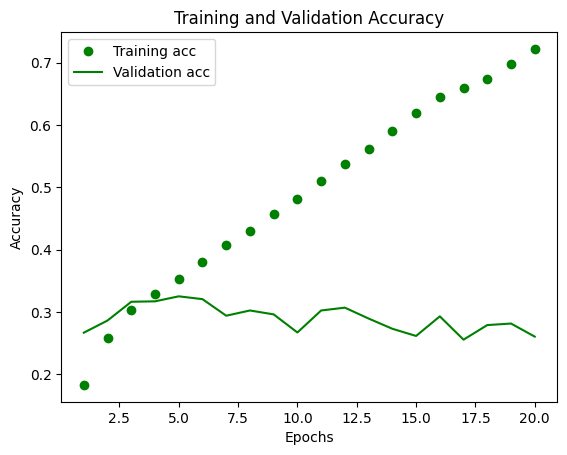

In [194]:
plot_train(CNN_static_glove_multiclass_history)